In [1]:
# Make sure cells are full width of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [31]:
%%bash
conda install -y -c anaconda pandasql 


Fetching package metadata .................
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/delphinel/anaconda/envs/ecolicomp:
#
pandasql                  0.7.3                    py27_0    anaconda


In [32]:
!pip install pandasql

In [2]:
import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

### First, we will process result of megablast analysis. 

The data was generated with the following command:

`blastn -query ecoli_genomes_only.fna -db ecg -outfmt "6 qaccver saccver pident length mismatch gapopen qstart qend qlen sstart send slen" -num_threads 8 > blast.tab `

**Note** that this is a **non standard** list of output fields! 

The resulting file is enormous as it contains many small alignemnts and large amount of self hits. Below we get rid of those.

In [34]:
# Create two filtered down files

# !cat blast.tab | awk '$1!=$2 && $4 > 10000' > blast_10K.tab

In [3]:
%%bash
#cat blast.tabular | awk '$1!=$2 && $4 > 100000' > blast_100K.tab
head blast_100K.tab

U00096.3	CP012868.1	100.000	4641667	1	7	1	4641652	4641652	4641665	1	4641665
U00096.3	CP012869.1	99.999	4641686	3	10	1	4641652	4641652	4641684	1	4641684
U00096.3	CP012870.1	99.999	4641691	3	12	1	4641652	4641652	4641689	1	4641689
U00096.3	CP026028.1	100.000	3340961	2	4	1300694	4641652	4641652	1298718	4639673	4639673
U00096.3	CP026028.1	100.000	1040823	1	1	258676	1299498	4641652	257900	1298721	4639673
U00096.3	CP026028.1	100.000	257907	0	0	1	257907	4641652	1	257907	4639673
U00096.3	CP014225.1	100.000	2423294	4	3	1873031	4296322	4641652	70230	2493522	4659625
U00096.3	CP014225.1	100.000	1097585	0	1	1	1097583	4641652	2838742	3936326	4659625
U00096.3	CP014225.1	99.998	611102	1	9	1209603	1820698	4641652	4048527	4659625	4659625
U00096.3	CP014225.1	99.997	345710	9	1	4295945	4641652	4641652	2493032	2838741	4659625


In [41]:
%%bash
gunzip blast_100K.tab.gz

In [4]:
# Read data in and name columns
bl = pd.read_table("blast_100K.tab",names=['q','t','id','len','mism','gap','qstart','qend','qlen','tstart','tend','tlen'])

In [5]:
bl.head()

,q,t,id,len,mism,gap,qstart,qend,qlen,tstart,tend,tlen
0,U00096.3,CP012868.1,100.000,4641667,1,7,1,4641652,4641652,4641665,1,4641665
1,U00096.3,CP012869.1,99.999,4641686,3,10,1,4641652,4641652,4641684,1,4641684
2,U00096.3,CP012870.1,99.999,4641691,3,12,1,4641652,4641652,4641689,1,4641689
3,U00096.3,CP026028.1,100.000,3340961,2,4,1300694,4641652,4641652,1298718,4639673,4639673
4,U00096.3,CP026028.1,100.000,1040823,1,1,258676,1299498,4641652,257900,1298721,4639673


In [7]:
# Group by target/query combination and compute sum of alignments for each combination and minimum genome length (e.g., min(q,t)). 
bl_max_align_len = pysqldf("select q, t, min(qlen,tlen) as len, sum(len) as align_len from bl group by q, t")

In [8]:
bl_max_align_len.describe()

,len,align_len
count,8.931000e+04,8.931000e+04
mean,4.789096e+06,7.132580e+05
std,2.289110e+05,1.064576e+06
min,3.976195e+06,1.000010e+05
25%,4.624968e+06,1.131720e+05
50%,4.746578e+06,2.433280e+05
75%,4.914884e+06,7.600148e+05
max,5.770602e+06,5.662829e+06


In [ ]:
%%bash
conda clean --index-cache
conda install -y -c conda-forge matplotlib 

In [ ]:
!pip install -U matplotlib


In [9]:
#%matplotlib inline  
import matplotlib.pyplot as plt

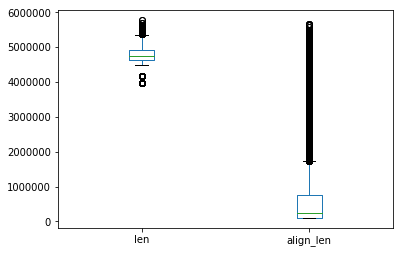

In [10]:
bl_max_align_len.plot.box()

In [11]:
bl_filt = pysqldf("select q, t, align_len, len, cast (align_len as float)/len as dist from bl_max_align_len")

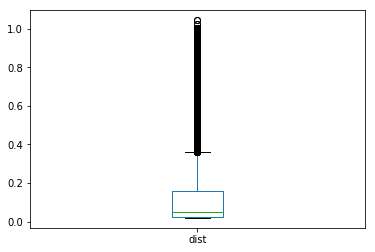

In [12]:
bl_filt['dist'].plot.box()

The problem with `align_len/len` as a distance measure is that it is >1 in some instances. We need to cap it at 1. 

In [13]:
bl_filt = pysqldf("select q, t, align_len, len, min(dist, 1) as dist from bl_filt")

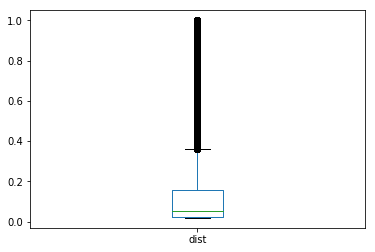

In [14]:
bl_filt['dist'].plot.box()

In [15]:
bl_filt.head()

,q,t,align_len,len,dist
0,AE014075.1,AP009378.1,448994,4717338,0.095180
1,AE014075.1,CP000247.1,896079,4938920,0.181432
2,AE014075.1,CP000468.1,991805,5082025,0.195159
3,AE014075.1,CP001671.1,3414113,5131397,0.665338
4,AE014075.1,CP001855.1,1251380,4747819,0.263569


Now that the dist is capped at 1, let's convert it into a proper distance by computing  (1 - dist) 

In [16]:
bl_filt = pysqldf("select q, t, align_len, len, 1 - dist as dist from bl_filt")

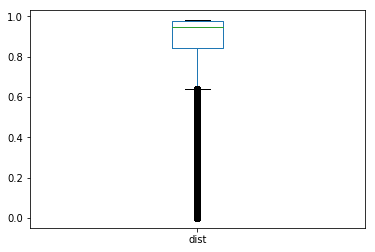

In [17]:
bl_filt['dist'].plot.box()

In [18]:
# Convert three columns of bl_filt to numpy array
dist_as_array = bl_filt[['q','t','dist']].values

In [19]:
dist_as_array[0][0:3]

array([u'AE014075.1', u'AP009378.1', 0.9048204729023022], dtype=object)

In [20]:
# Convert numpy array to a dictionary where q ant are keys
dist_as_dict = {}
for row in dist_as_array:
    dist_as_dict[row[1]]={}
    dist_as_dict[row[0]]={}
    
for row in dist_as_array :
    dist_as_dict[row[1]][row[0]]=row[2]

In [21]:
dist_as_dict['AE014075.1']

{u'AP009378.1': 0.90482026091834,
 u'CP000247.1': 0.8185678245446373,
 u'CP000468.1': 0.8048405901190963,
 u'CP001671.1': 0.3346620813006672,
 u'CP001855.1': 0.7364305589577025,
 u'CP001969.1': 0.8362648219602955,
 u'CP002167.1': 0.8169796473592198,
 u'CP002211.1': 0.29029177200794065,
 u'CP002212.1': 0.29029177200794065,
 u'CP005930.1': 0.9001751047006817,
 u'CP006784.1': 0.930065821458271,
 u'CP006830.1': 0.8274326844257384,
 u'CP007149.1': 0.8316949830156941,
 u'CP007275.1': 0.8000899899475912,
 u'CP007799.1': 0.48964814196047424,
 u'CP009072.1': 0.3791435081733394,
 u'CP010151.1': 0.867846271210292,
 u'CP010876.1': 0.9284042496294067,
 u'CP011915.1': 0.8247379218218895,
 u'CP012379.1': 0.8104253661150395,
 u'CP012625.1': 0.8337189534337235,
 u'CP012631.1': 0.82502116712901,
 u'CP012633.1': 0.8412290708011995,
 u'CP012635.1': 0.8290066464708612,
 u'CP013658.1': 0.9297470637375256,
 u'CP013831.1': 0.954612321835492,
 u'CP013835.1': 0.9322329580662534,
 u'CP013837.1': 0.95158894286469

In [22]:
# Covert it to a matrix
dist_matrix = pd.DataFrame(dist_as_dict).T.fillna(1)

In [23]:
dist_matrix.head()

,AE014075.1,AM946981.2,AP009048.1,AP009240.1,AP009378.1,AP010953.1,AP010960.1,AP012030.1,AP012306.1,AP017610.1,...,LM995446.1,LN832404.1,LT601384.1,LT615377.1,LT615378.1,LT838196.1,LT883142.1,LT903847.1,LT906474.1,U00096.3
AE014075.1,1.00000,1.000000,1.000000,1.000000,0.90482,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.949982,1.000000,1.000000
AM946981.2,1.00000,1.000000,0.974699,1.000000,1.00000,1.000000,1.000000,1.000000,0.972939,1.000000,...,0.974699,0.974699,0.970476,0.974699,0.974699,0.850059,0.885097,1.000000,0.911871,0.974699
AP009048.1,1.00000,0.974699,1.000000,0.969072,1.00000,0.977681,0.977681,0.172585,0.478005,0.977665,...,0.189135,0.179722,0.738840,0.179722,0.179723,0.673971,0.872128,1.000000,0.791710,0.043604
AP009240.1,1.00000,1.000000,0.969072,1.000000,1.00000,0.908196,0.898895,1.000000,0.964164,1.000000,...,0.968662,0.969017,1.000000,0.969017,0.969017,1.000000,1.000000,1.000000,1.000000,0.969041
AP009378.1,0.90482,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.978793,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
%%bash
head matrix.txt

AE014075.1AM946981.2AP009048.1AP009240.1AP009378.1AP010953.1AP010960.1AP012030.1AP012306.1AP017610.1AP017617.1AP017620.1BA000007.2CP000247.1CP000468.1CP000800.1CP000802.1CP000819.1CP000946.1CP000948.1CP000970.1CP001164.1CP001368.1CP001396.1CP001509.3CP001637.1CP001665.1CP001671.1CP001846.1CP001855.1CP001925.1CP001969.1CP002167.1CP002185.1CP002211.1CP002212.1CP002291.1CP002516.1CP002729.1CP002967.1CP002970.1CP003034.1CP003109.1CP003289.1CP003297.1CP003301.1CP004009.1CP005930.1CP005998.1CP006027.1CP006262.1CP006584.1CP006632.1CP006636.1CP006698.1CP006784.1CP006830.1CP006834.1CP007133.1CP007136.1CP007149.1CP007265.1CP007275.1CP007390.1CP007391.1CP007392.1CP007393.1CP007394.1CP007442.1CP007491.1CP007592.1CP007594.1CP007799.1CP008697.1CP008801.1CP008805.1CP008957.1CP009072.1CP009104.1CP009106.2CP009166.1CP009273.1CP009644.1CP009685.1CP009789.1CP009859.1CP010116.1CP010117.1CP010119.1CP010121.1CP010122.1CP010125.1CP010129.1CP010132.1CP010133.1CP010134.1CP010137.1CP010140.1CP010143.1CP010145.1

In [26]:
# Retrieve names
names = list(dist_matrix.columns.values)

In [27]:
# Convert matrix (a dataframe) to an array
matrix = dist_matrix.values.tolist()

In [28]:
matrix[0][1]

1.0

In [67]:
%%bash
conda install -y -c bioconda biopython 


Fetching package metadata ...............
Solving package specifications: .

Package plan for installation in environment /Users/delphinel/anaconda/envs/ecolicomp:

The following NEW packages will be INSTALLED:

    biopython:      1.70-np112py27_1      bioconda   
    libtiff:        4.0.9-0               conda-forge
    mmtf-python:    1.0.2-py27_0          bioconda   
    msgpack-python: 0.5.5-py27_0          conda-forge
    olefile:        0.45.1-py27_0         conda-forge
    pillow:         5.0.0-py27_0          conda-forge
    reportlab:      3.4.0-py27_0                     
    xz:             5.2.3-0               conda-forge

The following packages will be SUPERSEDED by a higher-priority channel:

    numpy:          1.14.1-py27h8a80b8c_1 anaconda    --> 1.12.1-py27h71f5d73_1

xz-5.2.3-0.tar 100% |###############################| Time: 0:00:00   1.52 MB/s
numpy-1.12.1-p 100% |###############################| Time: 0:00:00   6.35 MB/s
olefile-0.45.1 100% |####################

In [29]:
len(names)
len(matrix)


445

In [47]:
names

[u'AE014075.1',
 u'AM946981.2',
 u'AP009048.1',
 u'AP009240.1',
 u'AP009378.1',
 u'AP010953.1',
 u'AP010960.1',
 u'AP012030.1',
 u'AP012306.1',
 u'AP017610.1',
 u'AP017617.1',
 u'AP017620.1',
 u'BA000007.2',
 u'CP000247.1',
 u'CP000468.1',
 u'CP000800.1',
 u'CP000802.1',
 u'CP000819.1',
 u'CP000946.1',
 u'CP000948.1',
 u'CP000970.1',
 u'CP001164.1',
 u'CP001368.1',
 u'CP001396.1',
 u'CP001509.3',
 u'CP001637.1',
 u'CP001665.1',
 u'CP001671.1',
 u'CP001846.1',
 u'CP001855.1',
 u'CP001925.1',
 u'CP001969.1',
 u'CP002167.1',
 u'CP002185.1',
 u'CP002211.1',
 u'CP002212.1',
 u'CP002291.1',
 u'CP002516.1',
 u'CP002729.1',
 u'CP002967.1',
 u'CP002970.1',
 u'CP003034.1',
 u'CP003109.1',
 u'CP003289.1',
 u'CP003297.1',
 u'CP003301.1',
 u'CP004009.1',
 u'CP005930.1',
 u'CP005998.1',
 u'CP006027.1',
 u'CP006262.1',
 u'CP006584.1',
 u'CP006632.1',
 u'CP006636.1',
 u'CP006698.1',
 u'CP006784.1',
 u'CP006830.1',
 u'CP006834.1',
 u'CP007133.1',
 u'CP007136.1',
 u'CP007149.1',
 u'CP007265.1',
 u'CP007

In [30]:
# Convert matrix from a fill square into lower triangle
matrix_lt = []
for i, row in enumerate(matrix):
    matrix_lt.append(row[:(i+1)])

In [31]:
import Bio
import Bio.Phylo.TreeConstruction as tc
from Bio.Phylo.TreeConstruction import _DistanceMatrix


In [32]:
name2=[]
for i in names:
    name2.append(str(i))

In [33]:
# Initialize Bio distance matrix using names and lower triangle
dm = tc._DistanceMatrix(name2, matrix_lt)

In [36]:
import numpy

## Create Matrix file to use in R notebook

In [55]:
outputmatrix=open("dist_matrix.tab",'w')
for i in name2:
    outputmatrix.write(i+"\t")
outputmatrix.write("\n")
for i in name2:
    outputmatrix.write(i+"\t")
    for j in dm[i] :
            outputmatrix.write(str(j)+"\t")
    outputmatrix.write("\n")
    
outputmatrix.close()

In [52]:
print dm["AE014075.1"]

[0, 1.0, 1.0, 1.0, 0.9048204729023022, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8185678245446373, 0.8048405901190963, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3346620813006672, 1.0, 0.7364305589577025, 1.0, 0.8362648219602955, 0.8169796473592198, 1.0, 0.29029177200794065, 0.29029177200794065, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9001751047006817, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.930065821458271, 0.8274326844257384, 1.0, 1.0, 1.0, 0.8316949830156941, 1.0, 0.8000899899475912, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.48964814196047424, 1.0, 1.0, 1.0, 1.0, 0.37914818583654253, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.867846661024752, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [54]:
%%bash
head dist_matrix.tab

AE014075.1	AM946981.2	AP009048.1	AP009240.1	AP009378.1	AP010953.1	AP010960.1	AP012030.1	AP012306.1	AP017610.1	AP017617.1	AP017620.1	BA000007.2	CP000247.1	CP000468.1	CP000800.1	CP000802.1	CP000819.1	CP000946.1	CP000948.1	CP000970.1	CP001164.1	CP001368.1	CP001396.1	CP001509.3	CP001637.1	CP001665.1	CP001671.1	CP001846.1	CP001855.1	CP001925.1	CP001969.1	CP002167.1	CP002185.1	CP002211.1	CP002212.1	CP002291.1	CP002516.1	CP002729.1	CP002967.1	CP002970.1	CP003034.1	CP003109.1	CP003289.1	CP003297.1	CP003301.1	CP004009.1	CP005930.1	CP005998.1	CP006027.1	CP006262.1	CP006584.1	CP006632.1	CP006636.1	CP006698.1	CP006784.1	CP006830.1	CP006834.1	CP007133.1	CP007136.1	CP007149.1	CP007265.1	CP007275.1	CP007390.1	CP007391.1	CP007392.1	CP007393.1	CP007394.1	CP007442.1	CP007491.1	CP007592.1	CP007594.1	CP007799.1	CP008697.1	CP008801.1	CP008805.1	CP008957.1	CP009072.1	CP009104.1	CP009106.2	CP009166.1	CP009273.1	CP009644.1	CP009685.1	CP009789.1	CP009859.1	CP010116.1	CP010117.1	CP010119.1	CP010121.1	CP010122.1

In [34]:
# Compute phylogenetic tree using NJ
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

In [74]:
%%bash
conda install -y -c conda-forge pygraphviz 

Fetching package metadata ...............
Solving package specifications: .

Package plan for installation in environment /Users/delphinel/anaconda/envs/ecolicomp:

The following NEW packages will be INSTALLED:

    graphviz:   2.38.0-7      conda-forge
    pygraphviz: 1.4rc1-py27_0 conda-forge



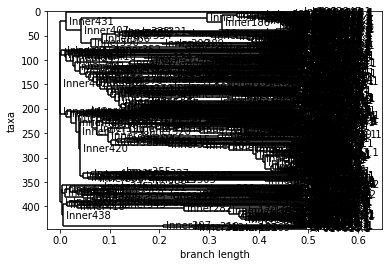

In [75]:
%matplotlib inline  
from Bio import Phylo
Phylo.draw(tree)

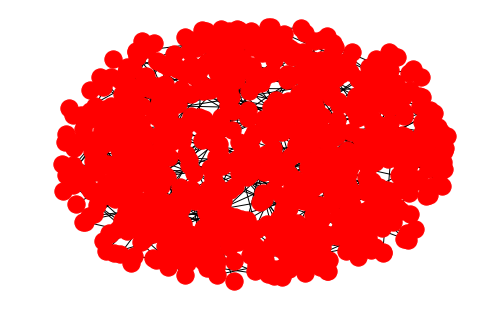

In [96]:
net = Phylo.to_networkx(tree)
nx.draw(net)
pylab.show()

In [94]:
Phylo.draw_ascii(tree)

                                                          _ LT903847.1
   ______________________________________________________|
  |                                                      |_ FM180568.1
  |
  |                                 _______________________ CP021207.1
  |                                |
  |                                |       ________________ CP018970.1
  |                                |      |
  |                                |      |             ___ CP014522.1
  |                                |      |      ______|
  |                                |      |     |      |___ CP014495.1
  |                                |      |    ,|
  |                                |      |    ||  _______ CP019008.1
  |                                |   ___|    ||_|
  |                                |  |   |    |  |    ___ CP019020.1
  |                                |  |   |  __|  |___|
  |                                |  |   | |  |      |____ CP014488.1
  | 

In [76]:
%%bash
conda install -y -c anaconda networkx 
conda install -y -c conda-forge graphviz 
conda install -y -c conda-forge matplotlib 
conda install -y -c bioconda pygraphviz 


Fetching package metadata .................
Solving package specifications: .

Package plan for installation in environment /Users/delphinel/anaconda/envs/ecolicomp:

The following NEW packages will be INSTALLED:

    networkx: 2.1-py27_0 anaconda

Fetching package metadata ...............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/delphinel/anaconda/envs/ecolicomp:
#
graphviz                  2.38.0                        7    conda-forge
Fetching package metadata ...............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/delphinel/anaconda/envs/ecolicomp:
#
matplotlib                2.1.2                    py27_0    conda-forge
Fetching package metadata ...............
Solving package specifications: .

Package plan for installation in environment /Users/delphinel/anaconda/envs/ecolicomp:

The following packages will be SUPERSEDED by a highe

In [91]:
import pygraphviz
import networkx as nx
import pylab

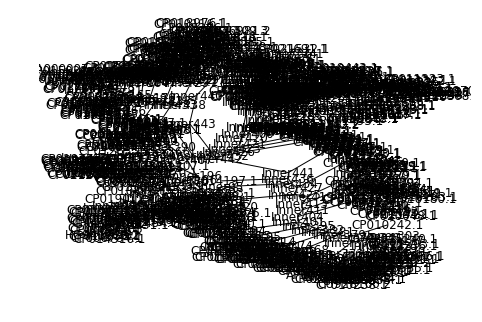

In [93]:
Phylo.draw_graphviz(tree,node_size=0)


In [78]:
import pylab

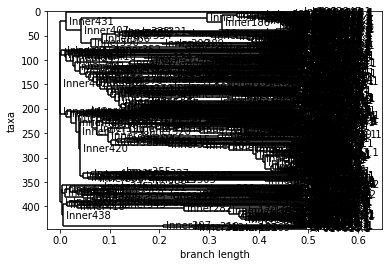

In [79]:
%matplotlib inline  
import matplotlib.pyplot as plt
Phylo.draw(tree)
pylab.show(tree)

In [80]:
#Phylo.draw_ascii(tree)

In [81]:
Phylo.write(tree,'ecoli.nwk', 'newick')

1

In [82]:
%%bash
conda install -y -c etetoolkit ete3 ete_toolchain

Fetching package metadata .................
Solving package specifications: .

Package plan for installation in environment /Users/delphinel/anaconda/envs/ecolicomp:

The following NEW packages will be INSTALLED:

    argtable2:     2.13-0                      etetoolkit 
    clustalo:      1.2.4-h8fd5eaf_0            etetoolkit 
    dialigntx:     1.0.2-h9803431_0            etetoolkit 
    ete3:          3.1.1-pyhf5214e1_0          etetoolkit 
    ete_toolchain: 3.0.0-h73706c9_0            etetoolkit 
    fasttree:      2.1-hda580f3_0              etetoolkit 
    iqtree:        1.5.5-h8fdce63_0            etetoolkit 
    kalign:        2.03-hf9ccdb1_0             etetoolkit 
    libgcc:        4.8.5-hdbeacc1_10                      
    libiconv:      1.15-0                      conda-forge
    libxml2:       2.9.7-0                     conda-forge
    libxslt:       1.1.32-0                    conda-forge
    lxml:          4.1.1-py27_0                conda-forge
    mafft:         

In [83]:
from ete3 import Tree
t = Tree( "((a,b),c);" )
t.show()